In [1]:
import os
import json
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact, fixed, IntSlider
from copy import deepcopy

In [2]:
numGames = 1

In [3]:
desFile = 'EUW1_6760045867.json'

In [4]:
pId1 = 3
pId2 = 8

In [5]:
def FindDesiredPosition(pId1):
    if pId1 == 1:
        desPos = 'Top'
    elif pId1 == 2:
        desPos = 'Jungle'
    elif pId1 == 3:
        desPos = 'Middle'
    elif pId1 == 4:
        desPos = 'Bottom'
    elif pId1 == 5:
        desPos = 'Utility'
    else:
        desPos = "error"  # It's better to set desPos to "error" instead of printing it, for consistency
    return desPos

desPos = FindDesiredPosition(pId1)


# Ingame Data: Process and Cleaning

In [10]:
def cleanAndSaveSingleIngameFile(rawFilePath, cleanedFolderPath, columnsToExclude, displayNoZero, eventsToExclude):
    global desFile
    if not os.path.exists(cleanedFolderPath):
        os.makedirs(cleanedFolderPath)

    # Derive the cleaned file path from rawFilePath
    filename = os.path.basename(rawFilePath)  # Extracts filename from the full path
    cleanedFilePath = os.path.join(cleanedFolderPath, filename)

    with open(rawFilePath, "r", encoding="utf-8") as file:
        data = json.load(file)

    cleanedData = cleanData(data, columnsToExclude, displayNoZero, eventsToExclude)

    with open(cleanedFilePath, "w", encoding="utf-8") as file:
        json.dump(cleanedData, file, indent=4, ensure_ascii=False)

    print(f"Processed {filename} and saved the cleaned data.")

eventsToExclude = ['WARD_PLACED', 'SKILL_LEVEL_UP', 'ITEM_DESTROYED', 'WARD_KILL', 'ITEM_SOLD', 'ITEM_UNDO']
columnsToExclude = ['magicDamageDone', 'magicDamageDoneToChampions', 'magicDamageTaken', 
                    'physicalDamageDone', 'physicalDamageDoneToChampions', 'physicalDamageTaken', 
                    'trueDamageDone', 'trueDamageDoneToChampions', 'trueDamageTaken', 'timeEnemySpentControlled']
displayNoZero = True

In [11]:
rawFilePath = f"D:/EUW/DemoData/Ingame/{desFile}"
cleanedFolderPath = "D:/EUW/DemoData/Ingame/Cleaned" 
cleanAndSaveSingleIngameFile(rawFilePath, cleanedFolderPath, columnsToExclude, displayNoZero, eventsToExclude)

Processed EUW1_6760045867.json and saved the cleaned data.


In [12]:
def consolidateAndFilterIngameData(directoryPath, outputFilePath):
    global desPos
    global desFile
    consolidatedData = {}
    gamesProcessed = 0

    for filename in os.listdir(directoryPath):
        if gamesProcessed > numGames:
            break

        filePath = os.path.join(directoryPath, filename)
        
        if os.path.isdir(filePath) or not filePath.endswith('.json'):
            print(f"Skipping: {filePath}")  # Debug print for skipping
            continue

        with open(filePath, 'r', encoding='utf-8') as file:
            ingameData = json.load(file)
        
        relevantData = {
            'frameInterval': ingameData['info'].get('frameInterval', 60000),
            'frames': [],
            'gameEnd': None,
            'allBuildingKills': []  # List to store all BUILDING_KILL events
        }
        
        gameDuration = 0

        for frame in ingameData['info'].get('frames', []):
            newFrame = {'participantFrames': {}, 'events': []}
            
            # Process participant frames for IDs 3 and 8
            for participantId, participantInfo in frame.get('participantFrames', {}).items():
                if int(participantId) in [pId1, pId2]:
                    newFrame['participantFrames'][participantId] = participantInfo

            # Process all BUILDING_KILL events and add them to the allBuildingKills list
            for event in frame.get('events', []):
                if event['type'] == 'BUILDING_KILL':
                    relevantData['allBuildingKills'].append(event)

            # Process CHAMPION_KILL and ELITE_MONSTER_KILL events based on participation by IDs 3 or 8
            for event in frame.get('events', []):
                if event['type'] in ['CHAMPION_KILL', 'ELITE_MONSTER_KILL']:
                    participants = [event.get('killerId')] + event.get('assistingParticipantIds', [])
                    if 'victimId' in event:
                        participants.append(event['victimId'])
                    if any(pid in [pId1, pId2] for pid in participants):
                        newFrame['events'].append(event)

            if newFrame['participantFrames'] or newFrame['events']:
                relevantData['frames'].append(newFrame)
                
            # Look for GAME_END event to capture game duration and winning team
            if 'GAME_END' not in relevantData:  # Ensure we only capture this once per game
                for event in frame.get('events', []):
                    if event['type'] == 'GAME_END':
                        relevantData['gameEnd'] = {
                            'winningTeam': event.get('winningTeam'),
                            'timestamp': event.get('timestamp')
                        }
                        gameDuration = event.get('timestamp')
                        break

        gamesProcessed += 1

        if gameDuration < 300000:  # Skip if game duration is less than 5 minutes
            continue

        matchId = ingameData.get('metadata', {}).get('matchId', f'unknown_{gamesProcessed}')
        consolidatedData[matchId] = relevantData
        
    os.makedirs(os.path.dirname(outputFilePath), exist_ok=True)

    with open(outputFilePath, 'w', encoding='utf-8') as outFile:
        json.dump(consolidatedData, outFile, indent=4)
    
    print(f"Consolidated and filtered data for {gamesProcessed} games has been saved to {outputFilePath}")

In [15]:
directoryPath = f"D:/EUW/DemoData/Ingame/Cleaned"
outputFilePath = f"D:/EUW/demoData/Ingame/{desPos}Ingame{desFile}"
consolidateAndFilterIngameData(directoryPath, outputFilePath)

Consolidated and filtered data for 1 games has been saved to D:/EUW/demoData/Ingame/MiddleIngameEUW1_6760045867.json


In [16]:
def saveStructuredAttributesForIngameData(filePath, numGames, outputFilePath):
    try:
        with open(filePath, 'r') as file:
            data = json.load(file)
    except Exception as e:
        print(f"Failed to read or parse JSON from {filePath}: {e}")
        return

    global desPos
    structuredGamesData = {}
    gamesProcessed = 0

    for gameId, gameData in data.items():
        if gamesProcessed >= numGames:
            break

        structuredDatapId1, structuredDatapId2 = {'frames': []}, {'frames': []}
        gameEndData = gameData.get('gameEnd', None)
        
        allBuildingKills = gameData.get('allBuildingKills', [])
        
        for frame in gameData.get('frames', []):
            frameDatapId1 = {'totalGold': None, 'xp': None, 'events': [], 'position': {}, 'damageStats': {}}
            frameDatapId2 = {'totalGold': None, 'xp': None, 'events': [], 'position': {}, 'damageStats': {}}

            # Process data for participant 3
            pDataId1 = frame.get('participantFrames', {}).get(f'{pId1}')
            if pDataId1:
                frameDatapId1['totalGold'] = pDataId1.get('totalGold', 0)
                frameDatapId1['xp'] = pDataId1.get('xp', 0)
                frameDatapId1['position'] = pDataId1.get('position', {})
                frameDatapId1['damageStats'] = pDataId1.get('damageStats', {})

            # Process data for participant 8
            pDataId2 = frame.get('participantFrames', {}).get(f'{pId2}')
            if pDataId2:
                frameDatapId2['totalGold'] = pDataId2.get('totalGold', 0)
                frameDatapId2['xp'] = pDataId2.get('xp', 0)
                frameDatapId2['position'] = pDataId2.get('position', {})
                frameDatapId2['damageStats'] = pDataId2.get('damageStats', {})

            # Process relevant events for this frame
            for event in frame.get('events', []):
                # CHAMPION_KILL events processing
                if event['type'] == 'CHAMPION_KILL' and (event.get('killerId') in [pId1, pId2] or event.get('victimId') in [pId1, pId2] or set(event.get('assistingParticipantIds', [])).intersection({pId1, pId2})):
                    relevant_event = {
                        'killerId': event.get('killerId'),
                        'victimId': event.get('victimId'),
                        'timestamp': event.get('timestamp'),
                        'position': event.get('position'),
                        'assistingParticipants': event.get('assistingParticipantIds', [])
                    }
                    if pId1 in [event.get('killerId'), event.get('victimId')] or pId1 in event.get('assistingParticipantIds', []):
                        frameDatapId1['events'].append(relevant_event)
                    if pId2 in [event.get('killerId'), event.get('victimId')] or pId2 in event.get('assistingParticipantIds', []):
                        frameDatapId2['events'].append(relevant_event)

                # ELITE_MONSTER_KILL events processing
                if event['type'] == 'ELITE_MONSTER_KILL' and (event.get('killerId') in [pId1, pId2] or set(event.get('assistingParticipantIds', [])).intersection({pId1,pId2})):
                    elite_event = {
                        'killerId': event.get('killerId'),
                        'killerTeamId': event.get('killerTeamId'),
                        'monsterType': event.get('monsterType'),
                        'position': event.get('position'),
                        'timestamp': event.get('timestamp'),
                        'assistingParticipants': event.get('assistingParticipantIds', [])
                    }
                    if pId1 in [event.get('killerId')] or pId1 in event.get('assistingParticipantIds', []):
                        frameDatapId1['events'].append(elite_event)
                    if pId2 in [event.get('killerId')] or pId2 in event.get('assistingParticipantIds', []):
                        frameDatapId2['events'].append(elite_event)


            structuredDatapId1['frames'].append(frameDatapId1)
            structuredDatapId2['frames'].append(frameDatapId2)

        structuredGamesData[gameId] = {
            f'{pId1}': structuredDatapId1,
            f'{pId2}': structuredDatapId2,
            'allBuildingKills': allBuildingKills,  # Include the allBuildingKills list
            'gameEnd': gameEndData
        }
        gamesProcessed += 1

    try:
        with open(outputFilePath, 'w', encoding='utf-8') as outputFile:
            json.dump(structuredGamesData, outputFile, indent=4)
        print(f"Structured data for the first {numGames} games has been saved to {outputFilePath}")
    except Exception as e:
        print(f"Failed to write structured data to {outputFilePath}: {e}")

In [17]:
filePath = f"D:/EUW/demoData/Ingame/{desPos}Ingame{desFile}"
outputFilePath = f"D:/EUW/demoData/Ingame/Processed{desPos}Ingame{desFile}"
saveStructuredAttributesForIngameData(filePath, numGames, outputFilePath)

Structured data for the first 1 games has been saved to D:/EUW/demoData/Ingame/ProcessedMiddleIngameEUW1_6760045867.json


In [18]:
def initializeTowerStates():
    towerStates = {
        '100_TOP_OUTER': {'x': 981, 'y': 10441, 'alive': 1},
        '100_TOP_INNER': {'x': 1512, 'y': 6699, 'alive': 1},
        '100_TOP_BASE': {'x': 1169, 'y': 4287, 'alive': 1},
        '100_MID_OUTER': {'x': 5846, 'y': 6396, 'alive': 1},
        '100_MID_INNER': {'x': 5048, 'y': 4812, 'alive': 1},
        '100_MID_BASE': {'x': 3651, 'y': 3696, 'alive': 1},
        '100_BOT_OUTER': {'x': 10504, 'y': 1029, 'alive': 1},
        '100_BOT_INNER': {'x': 6919, 'y': 1483, 'alive': 1},
        '100_BOT_BASE': {'x': 4281, 'y': 1253, 'alive': 1},
        '100_NEXUS_NORTH': {'x': 1748, 'y': 2270, 'alive': 1},
        '100_NEXUS_SOUTH': {'x': 2177, 'y': 1807, 'alive': 1},
        
        '200_TOP_OUTER': {'x': 4318, 'y': 13875, 'alive': 1},
        '200_TOP_INNER': {'x': 7943, 'y': 13411, 'alive': 1},
        '200_TOP_BASE': {'x': 10481, 'y': 13650, 'alive': 1},
        '200_MID_OUTER': {'x': 8955, 'y': 8510, 'alive': 1},
        '200_MID_INNER': {'x': 9767, 'y': 10113, 'alive': 1},
        '200_MID_BASE': {'x': 11134, 'y': 11207, 'alive': 1},
        '200_BOT_OUTER': {'x': 13866, 'y': 4505, 'alive': 1},
        '200_BOT_INNER': {'x': 13327, 'y': 8226, 'alive': 1},
        '200_BOT_BASE': {'x': 13624, 'y': 10572, 'alive': 1},
        '200_NEXUS_NORTH': {'x': 12611, 'y': 13084, 'alive': 1},
        '200_NEXUS_SOUTH': {'x': 12872, 'y': 12548, 'alive': 1},
    }
    return towerStates

def updateTowerStatesBasedOnEvents(events, currentFrameTimestamp, towerStates, frameInterval=60000):
    for event in events:
        if event['type'] == 'BUILDING_KILL' and event['buildingType'] == 'TOWER_BUILDING':
            eventMinute = event['timestamp'] // frameInterval  # Calculate the minute of the event
            for towerKey, towerInfo in towerStates.items():
                if towerInfo['x'] == event['position']['x'] and towerInfo['y'] == event['position']['y']:
                    if event['timestamp'] <= currentFrameTimestamp:
                        towerStates[towerKey]['alive'] = 0
                        towerStates[towerKey]['destructionMinute'] = eventMinute  # Store the minute of destruction
    return towerStates

def enrichGameDataWithTowerStates(inputFilePath, outputFilePath):
    with open(inputFilePath, 'r') as file:
        data = json.load(file)
    
    global desPos

    for matchId, matchData in data.items():
        allBuildingKills = matchData.get('allBuildingKills', [])
        
        # Initialize tower states once for each match
        towerStates = initializeTowerStates()

        frames = matchData.get('frames', [])
        for frameIndex, frame in enumerate(frames):
            # Assuming each frame represents 1 minute, converting to milliseconds for timestamp comparison
            currentFrameEndTimestamp = (frameIndex + 1) * 60000

            # Make a deep copy of tower states to ensure independent modification
            updatedTowerStates = deepcopy(towerStates)
            
            # Update tower states based on building kills up to the current frame's timestamp
            updatedTowerStates = updateTowerStatesBasedOnEvents(allBuildingKills, 
                                                                currentFrameEndTimestamp, 
                                                                updatedTowerStates)

            # Assign the deeply copied and updated tower states back to the frame
            frame['towerStates'] = updatedTowerStates

            # Reflect any destruction in the main towerStates for subsequent frames
            for towerKey, towerInfo in updatedTowerStates.items():
                if towerInfo['alive'] == 0:
                    towerStates[towerKey]['alive'] = 0  # Update the main towerStates to reflect destruction

    with open(outputFilePath, 'w', encoding='utf-8') as outputFile:
        json.dump(data, outputFile, indent=4)

    print("Game data enriched with tower states and saved.")

In [19]:
inputFilePath = f"D:/EUW/demoData/Ingame/{desPos}Ingame{desFile}"
outputFilePath = f"D:/EUW/demoData/Ingame/Processed{desPos}Ingame{desFile}"
enrichGameDataWithTowerStates(inputFilePath, outputFilePath)

Game data enriched with tower states and saved.


--------------------------------------------------------------------------------------------------------------------------

# Postgame Data: Process and Clean

In [29]:
def filterPostData(data):
    # Define the keys to keep in the info section
    infoKeysToKeep = {'endOfGameResult', 'gameCreation', 'gameDuration', 'gameEndTimestamp', 'gameId',
                      'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId',
                      'platformId', 'queueId', 'teams', 'tournamentCode'}
    
    # Define participant keys to keep
    participantKeysToKeep = {'championName', 'damageDealtToBuildings', 'damageDealtToObjectives',
                             'damageDealtToTurrets', 'goldEarned', 'goldSpent', 'individualPosition',
                             'inhibitorTakedowns', 'lane', 'participantId', 'perks', 'puuid', 'riotIdGameName',
                             'riotIdTagline', 'role', 'summonerId', 'summonerName', 'teamEarlySurrendered', 'teamId',
                             'teamPosition', 'totalAllyJungleMinionsKilled', 'totalDamageDealt',
                             'totalDamageDealtToChampions', 'totalDamageTaken', 'totalEnemyJungleMinionsKilled',
                             'turretTakedowns', 'visionScore', 'wardsKilled', 'wardsPlaced', 'win', 'challenges'}

    # Define the keys to keep within the challenges dictionary
    challengesKeysToKeep = {'controlWardsPlaced', 'dragonTakedowns', 'goldPerMinute', 'kda',
                            'killParticipation', 'killsNearEnemyTurret', 'killsUnderOwnTurret',
                            'maxCsAdvantageOnLaneOpponent', 'maxLevelLeadLaneOpponent', 'soloKills',
                            'stealthWardsPlaced', 'takedownOnFirstTurret', 'takedowns', 'teamBaronKills',
                            'teamDamagePercentage', 'teamElderDragonKills', 'teamRiftHeraldKills',
                            'visionScorePerMinute', 'wardTakedowns'}
    
    # Keep entire metadata
    filteredData = {'metadata': data['metadata']}
    
    # Filter info section
    filteredInfo = {key: data['info'][key] for key in data['info'] if key in infoKeysToKeep}
    
    # Filter participants
    filteredParticipants = []
    for participant in data['info']['participants']:
        filteredParticipant = {}
        for key in participant:
            if key in participantKeysToKeep:
                if key == 'challenges':
                    # Special handling for the challenges dictionary
                    challenges = participant[key]
                    filteredChallenges = {ckey: challenges[ckey] for ckey in challenges if ckey in challengesKeysToKeep}
                    filteredParticipant[key] = filteredChallenges
                else:
                    filteredParticipant[key] = participant[key]
        filteredParticipants.append(filteredParticipant)
    
    # Add filtered info and participants to the filteredData
    filteredInfo['participants'] = filteredParticipants
    filteredData['info'] = filteredInfo

    return filteredData

def cleanAndSaveSinglePostGameData(rawFilePath, cleanedFolderPath):
    # Ensure the cleaned data folder exists
    if not os.path.exists(cleanedFolderPath):
        os.makedirs(cleanedFolderPath)

    # Extract the filename from rawFilePath to use for the cleaned file
    filename = os.path.basename(rawFilePath)
    cleanedFilePath = os.path.join(cleanedFolderPath, filename)

    # Read the raw game data
    with open(rawFilePath, "r", encoding="utf-8") as file:
        data = json.load(file)

    # Clean the data using filterPostData
    cleanedData = filterPostData(data)

    # Save the cleaned data
    with open(cleanedFilePath, "w", encoding="utf-8") as file:
        json.dump(cleanedData, file, indent=4, ensure_ascii=False)
    
    print(f"Processed {filename} and saved the cleaned data.")

In [30]:
rawFilePath  = f"D:/EUW/demoData/Postgame/{desFile}"
cleanedFolderPath = f"D:/EUW/DemoData/Postgame/Cleaned"
cleanAndSaveSinglePostGameData(rawFilePath, cleanedFolderPath)

Processed EUW1_6760045867.json and saved the cleaned data.


In [32]:
def processAndSaveGameData(directoryPath, pId1):
    global desPos
    if desPos == "error":
        print("Invalid participant ID provided.")
        return

    outputFilePath = f"D:/EUW/DemoData/Postgame/Processed{desPos}Postgame{desFile}"
    matchesData = {}

    for filename in os.listdir(directoryPath):
        filePath = os.path.join(directoryPath, filename)

        with open(filePath, 'r', encoding='utf-8') as file:
            matchData = json.load(file)

            if matchData['info']['gameDuration'] < 300:
                continue

            matchId = matchData['metadata']['matchId']
            matchDetails = {}

            for participant in matchData['info']['participants']:
                if participant['participantId'] in [pId1, pId2]:
                    lanerData = {
                        'damageDealtToObjectives': participant.get('damageDealtToObjectives', 0),
                        'goldEarned': participant.get('goldEarned', 0),
                        'totalDamageDealt': participant.get('totalDamageDealt', 0),
                        'totalDamageDealtToChampions': participant.get('totalDamageDealtToChampions', 0),
                        'visionScore': participant.get('visionScore', 0),
                        'turretTakedowns': participant.get('turretTakedowns', 0),
                        'wardsPlaced': participant.get('wardsPlaced', 0),
                        'wardsKilled': participant.get('wardsKilled', 0),
                    }
                    matchDetails[str(participant['participantId'])] = lanerData

            if matchDetails:
                matchesData[matchId] = matchDetails

    outputDirectory = os.path.dirname(outputFilePath)
    if not os.path.exists(outputDirectory):
        os.makedirs(outputDirectory)

    with open(outputFilePath, 'w', encoding='utf-8') as outputFile:
        json.dump(matchesData, outputFile, indent=4)

    print(f"Processed {desPos} game data saved to {outputFilePath}")

# Example usage
directoryPath = f"D:/EUW/DemoData/Postgame/Cleaned"
processAndSaveGameData(directoryPath, pId1)

Processed Middle game data saved to D:/EUW/DemoData/Postgame/ProcessedMiddlePostgameEUW1_6760045867.json


# Compare and Streamline Code

In [33]:
def identifyAndReportUniqueMatchIDs(file1, file2, matchIdKey='matchId'):
    # Load data from the first JSON file
    with open(file1, 'r') as f1:
        data1 = json.load(f1)
    # Extract match IDs from the list
    matchIDsFile1 = set(item[matchIdKey] for item in data1 if matchIdKey in item)
    
    # Load data from the second JSON file
    with open(file2, 'r') as f2:
        data2 = json.load(f2)
    # Extract match IDs from the list
    matchIDsFile2 = set(item[matchIdKey] for item in data2 if matchIdKey in item)
    
    # Find match IDs that are unique to each file
    uniqueToFile1 = matchIDsFile1 - matchIDsFile2
    uniqueToFile2 = matchIDsFile2 - matchIDsFile1
    
    # Calculate the total amount of unique match IDs
    totalUniqueFile1 = len(uniqueToFile1)
    totalUniqueFile2 = len(uniqueToFile2)
    
    # Print out the unique match IDs and their total count
    if uniqueToFile1:
        print(f"Match IDs unique to {file1}:")
        for matchID in uniqueToFile1:
            print(matchID)
        print(f"Total unique match IDs in {file1}: {totalUniqueFile1}")
    else:
        print(f"No match IDs unique to {file1}")
        
    if uniqueToFile2:
        print(f"Match IDs unique to {file2}:")
        for matchID in uniqueToFile2:
            print(matchID)
        print(f"Total unique match IDs in {file2}: {totalUniqueFile2}")
    else:
        print(f"No match IDs unique to {file2}")

In [34]:
file1 = f"D:/EUW/DemoData/Ingame/Processed{desPos}Ingame{desFile}"
file2 = f"D:/EUW/DemoData/Postgame/Processed{desPos}Postgame{desFile}"
identifyAndReportUniqueMatchIDs(file1, file2)

No match IDs unique to D:/EUW/DemoData/Ingame/ProcessedMiddleIngameEUW1_6760045867.json
No match IDs unique to D:/EUW/DemoData/Postgame/ProcessedMiddlePostgameEUW1_6760045867.json


In [35]:
def countGamesInJSON(filePath):
    with open(filePath, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Check if the data is a list or a dictionary and count accordingly
    if isinstance(data, list):
        return len(data)  # Each item in the list represents a game
    elif isinstance(data, dict):
        return len(data.keys())  # Each key in the dictionary represents a game
    else:
        return 0  # In case the data is neither a list nor a dictionary

# File paths
file1 = f"D:/EUW/DemoData/Ingame/Processed{desPos}Ingame{desFile}"
file2 = f"D:/EUW/DemoData/Postgame/Processed{desPos}Postgame{desFile}"

# Count the games in each file
gamesInFile1 = countGamesInJSON(file1)
gamesInFile2 = countGamesInJSON(file2)

print(f"Number of games in {file1}: {gamesInFile1}")
print(f"Number of games in {file2}: {gamesInFile2}")


Number of games in D:/EUW/DemoData/Ingame/ProcessedMiddleIngameEUW1_6760045867.json: 1
Number of games in D:/EUW/DemoData/Postgame/ProcessedMiddlePostgameEUW1_6760045867.json: 1


# Data Visualization

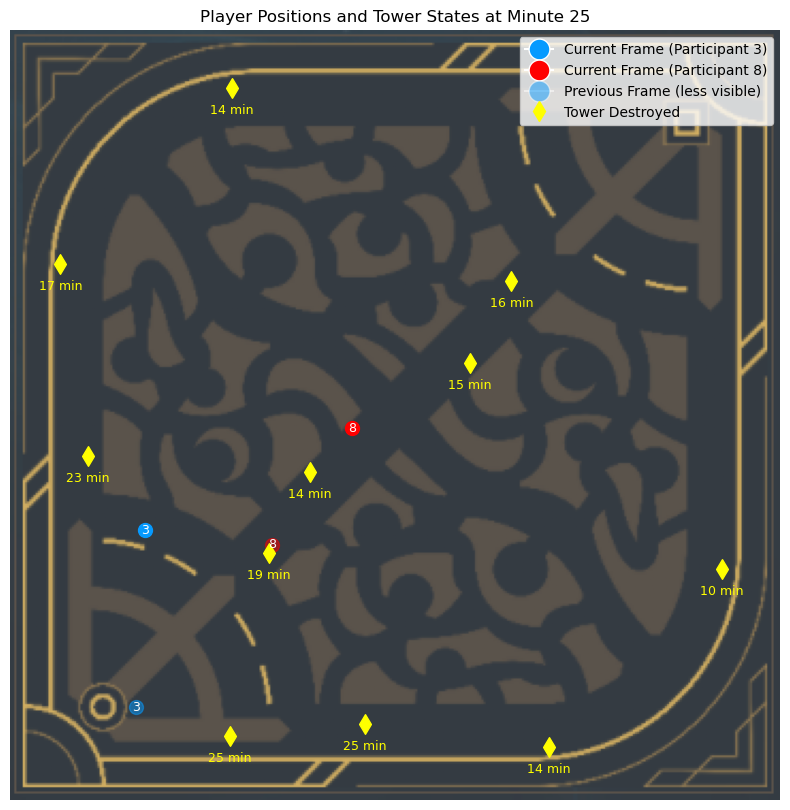

Dropdown(description='Play Style:', options=(('Offensive', 1), ('Defensive', 0)), value=1)

Dropdown(description='Participant:', options=('3', '8'), value='3')

Button(description='Submit', style=ButtonStyle())

Output()

IntSlider(value=25, continuous_update=False, description='Minute:', max=29)

In [53]:
def plotGameEventsWithTowers(backgroundImagePath, gameDataPath, matchId, targetMinute):
    global desPos
    gameData = loadGameData(gameDataPath, matchId)
    
    plt.figure(figsize=(10, 10))
    backgroundImage = mpimg.imread(backgroundImagePath)
    plt.imshow(backgroundImage, extent=[0, 15000, 0, 15000], alpha=0.8)
    plt.title(f'Player Positions and Tower States at Minute {targetMinute}')
    plt.xlim(0, 15000)
    plt.ylim(0, 15000)

    frames = gameData.get('frames', [])
    if targetMinute < len(frames):
        frame = frames[targetMinute]
        participantFrames = frame.get('participantFrames', {})
        for participantId, participantData in participantFrames.items():
            # Correct the function name and ensure it's called with the correct parameters
            plotParticipantPositions(frames, participantId, targetMinute)  # Use the function intended for plotting positions
            
        towerStates = frame.get('towerStates', {})
        plotTowerStates(towerStates)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label=f'Current Frame (Participant {pId1})', markerfacecolor='#069aff', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label=f'Current Frame (Participant {pId2})', markerfacecolor='red', markersize=15),
        plt.Line2D([0], [0], marker='o', color='w', label='Previous Frame (less visible)', markerfacecolor='#069aff', markersize=15, alpha=0.5),
        plt.Line2D([0], [0], color='yellow', marker='d', linestyle='None', markersize=10, label='Tower Destroyed')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.axis('off')
    plt.show()

def plotParticipantPositions(frames, participantId, targetMinute):
    color = '#069aff' if participantId == f'{pId1}' else 'red'
    # Initialize variables to store the previous and current position if found
    previousPosition = None
    currentPosition = None
    
    # Attempt to find the positions for the target and previous minutes
    if targetMinute < len(frames) and targetMinute > 0:
        previousPosition = frames[targetMinute - 1].get('participantFrames', {}).get(participantId, {}).get('position')
    if targetMinute < len(frames):
        currentPosition = frames[targetMinute].get('participantFrames', {}).get(participantId, {}).get('position')
    
    # Plot the previous position with lower opacity if it exists
    if previousPosition:
        plt.scatter(previousPosition['x'], previousPosition['y'], color=color, marker='o', s=100, alpha=0.5)
        plt.text(previousPosition['x'], previousPosition['y'], str(participantId), color='white', fontsize=9, ha='center', va='center')
    
    # Plot the current position with full opacity if it exists
    if currentPosition:
        plt.scatter(currentPosition['x'], currentPosition['y'], color=color, marker='o', s=100, alpha=1.0)
        plt.text(currentPosition['x'], currentPosition['y'], str(participantId), color='white', fontsize=9, ha='center', va='center')
        
def plotTowerStates(towerStates):
    for towerKey, towerInfo in towerStates.items():
        if towerInfo['alive'] == 0:  # Tower is destroyed
            plt.scatter(towerInfo['x'], towerInfo['y'], color='yellow', marker='d', s=100)
            destructionMinute = towerInfo.get('destructionMinute', 'Unknown')
            plt.text(towerInfo['x'], towerInfo['y'] - 500, f"{destructionMinute} min", color='yellow', fontsize=9, ha='center')

def interactivePlotFunction(gameDataPath, matchId):
    gameData = loadGameData(gameDataPath, matchId)
    maxMinutes = getGameDuration(gameDataPath, matchId)
    
    def updatePlot(targetMinute):
        clear_output(wait=True)
        plotGameEventsWithTowers(backgroundImagePath, gameDataPath, matchId, targetMinute)
        displayPlayStyleWidgets(gameDataPath, matchId, [f'{pId1}', f'{pId2}'], targetMinute)
        display(targetMinuteSlider)

    backgroundImagePath = '..\Demo\Material\lolMap.PNG'
    targetMinuteSlider = IntSlider(value=5, min=0, max=int(maxMinutes or 45)+1, step=1, description='Minute:', continuous_update=False)
    targetMinuteSlider.observe(lambda change: updatePlot(change['new']), names='value')

    display(targetMinuteSlider)
    updatePlot(targetMinuteSlider.value)

# Helper Functions
def loadGameData(gameDataPath, matchId):
    with open(gameDataPath, 'r') as file:
        gamesData = json.load(file)
    return gamesData.get(matchId, {})

def getGameDuration(gameDataPath, matchId):
    gameData = loadGameData(gameDataPath, matchId)
    if 'gameEnd' in gameData:
        return gameData['gameEnd']['timestamp'] / 60000  # Convert to minutes
    return None

def updatePlayStyle(gameDataPath, matchId, participantId, targetMinute, playStyle):
    with open(gameDataPath, 'r') as file:
        gamesData = json.load(file)

    # Accessing the specific participant's data within the target frame and updating playstyle
    participantData = gamesData[matchId]['frames'][targetMinute]['participantFrames'][participantId]
    participantData['playStyle'] = playStyle

    # Save the updated data back to the file
    with open(gameDataPath, 'w') as file:
        json.dump(gamesData, file, indent=4)

    print(f"Play style '{playStyle}' saved for Participant {participantId}, Frame {targetMinute}.")


def displayPlayStyleWidgets(gameDataPath, matchId, participantIds, targetMinute):
    styleDropdown = widgets.Dropdown(options=[('Offensive', 1), ('Defensive', 0)], description='Play Style:')
    participantDropdown = widgets.Dropdown(options=participantIds, description='Participant:')
    submitButton = widgets.Button(description='Submit')
    output = widgets.Output()

    def onSubmit(b):
        with output:
            playStyle = styleDropdown.value
            participantId = participantDropdown.value
            updatePlayStyle(gameDataPath, matchId, participantId, targetMinute, playStyle)
            clear_output()
            print(f"Play style updated to {playStyle} for Participant {participantId} at Minute {targetMinute}.")
    
    submitButton.on_click(onSubmit)
    display(styleDropdown, participantDropdown, submitButton, output)

# Set your file paths and match ID
gameDataPath = f'D:/EUW/DemoData/Ingame/Processed{desPos}Ingame{desFile}'
matchId = desFile.split('.')[0]

# Execute the interactive plot function
interactivePlotFunction(gameDataPath, matchId)

In [20]:
def calculateAndSaveAveragePlayStyle(gameDataPath, matchId):
    with open(gameDataPath, 'r') as file:
        gamesData = json.load(file)
    
    matchData = gamesData.get(matchId)
    if not matchData:
        print(f"No data found for match ID {matchId}")
        return
    
    # Initialize a dictionary to hold the average play styles
    averagePlayStyles = {}
    
    # Iterate through each participant (e.g., "3" and "8")
    for participantId in [f'{pId1}', f'{pId2}']:
        participantFrames = matchData['frames'][1:]  # Get all frames
        playStyleSum = 0
        playStyleCount = 0
        
        # Sum up all playStyle values and count them
        for frame in participantFrames:
            participantData = frame.get('participantFrames', {}).get(participantId, {})
            if 'playStyle' in participantData:  # Now accessing playStyle inside each participant's data
                playStyleSum += participantData['playStyle']
                playStyleCount += 1
        
        # Calculate the average play style if there are any annotated frames
        if playStyleCount > 0:
            averagePlayStyles[participantId] = playStyleSum / playStyleCount
        else:
            averagePlayStyles[participantId] = None  # or use 0 or any default value
    
    # Save the average play styles in the gameEnd section
    if 'gameEnd' not in matchData:
        matchData['gameEnd'] = {}
    
    matchData['gameEnd']['averagePlayStyle'] = averagePlayStyles
    
    # Write the updated data back to the file
    with open(gameDataPath, 'w') as file:
        json.dump(gamesData, file, indent=4)
    
    print("Average play styles saved:", averagePlayStyles)


In [21]:
gameDataPath = f'D:/EUW/ThreatTestData/Ingame/Processed{desPos}IngameThreatTestData.json'
matchId = 'EUW1_6844839591'
calculateAndSaveAveragePlayStyle(gameDataPath, matchId)

KeyError: 'frames'

# Conversion to CSV

In [ ]:
def gameDataToCsv(gameDataPath, matchId, outputCsvPath):
    with open(gameDataPath, 'r') as file:
        gamesData = json.load(file)

    gameData = gamesData.get(matchId, {})

    csvHeader = [
        'MatchId', 'ParticipantId', 'Frame', 'TotalGold', 'XP', 
        'Events', 'PositionX', 'PositionY', 'TotalDamageDone', 
        'TotalDamageDoneToChampions', 'TotalDamageTaken', 'PlayStyle', 'TowerStates'
    ]

    csvData = []

    frames = gameData.get('frames', [])
    for frameIndex, frame in enumerate(frames):
        if frameIndex == 0:  # Skip frame '0'
            continue
        
        towerStates = frame.get('towerStates', {})
        serializedTowerStates = json.dumps(towerStates)

        for participantId in [f'{pId1}', f'{pId2}']:
            participantData = frame.get('participantFrames', {}).get(participantId, {})
            events = participantData.get('events', [])  # Serialize events to JSON string
            playStyle = participantData.get('playStyle', '')

            row = [
                matchId,
                participantId,
                frameIndex,
                participantData.get('totalGold', '0'),
                participantData.get('xp', '0'),
                events,
                participantData.get('position', {}).get('x', '0'),
                participantData.get('position', {}).get('y', '0'),
                participantData.get('damageStats', {}).get('totalDamageDone', '0'),
                participantData.get('damageStats', {}).get('totalDamageDoneToChampions', '0'),
                participantData.get('damageStats', {}).get('totalDamageTaken', '0'),
                playStyle if playStyle else '0',
                serializedTowerStates if serializedTowerStates != '{}' else '0'
            ]
            csvData.append(row)

    with open(outputCsvPath, 'w', newline='', encoding='utf-8') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(csvHeader)
        writer.writerows(csvData)

    print(f"CSV file has been created at {outputCsvPath}")

# Example usage
gameDataPath = f'D:/EUW/ThreatTestData/Ingame/Processed{desPos}IngameThreatTestData.json'
outputCsvPath = f'D:/EUW/ThreatTestData/Ingame/Processed{desPos}IngameThreatTestCsvData.csv'
matchId = 'EUW1_6844839591'
gameDataToCsv(gameDataPath, matchId, outputCsvPath)

In [ ]:
def serialize_events_for_csv(events):
    if not events:  # Check if the events list is empty
        return "[]"

    serialized_events = []
    for event in events:
        # Example serialization for CHAMPION_KILL events, adjust as necessary for other types
        if event['type'] == 'CHAMPION_KILL':
            assists = ','.join(map(str, event.get('assistingParticipantIds', [])))
            event_str = f"[Killer={event.get('killerId')},Victim={event.get('victimId')},Assists={assists},Pos=({event.get('position', {}).get('x')},{event.get('position', {}).get('y')})]"
            
        # Serialize ELITE_MONSTER_KILL events
        elif event['type'] == 'ELITE_MONSTER_KILL':
            event_str = f"[Killer={event.get('killerId')},MonsterType={event.get('monsterType')},Team={event.get('killerTeamId')},Pos=({event.get('position', {}).get('x')},{event.get('position', {}).get('y')})]"
            serialized_events.append(event_str)
            
        else:
            event_str = f"Type={event['type']}"  # Generic serialization for other event types
        serialized_events.append(event_str)

    return "|".join(serialized_events).replace(',', ';')  # Use '|' to separate events and ';' to avoid CSV conflicts

def gameDataToCsv(gameDataPath, matchId, outputCsvPath):
    with open(gameDataPath, 'r') as file:
        gamesData = json.load(file)
    gameData = gamesData.get(matchId, {})
    csvHeader = ['MatchId', 'ParticipantId', 'Frame', 'TotalGold', 'XP', 'Events', 'PositionX', 'PositionY', 'TotalDamageDone', 'TotalDamageDoneToChampions', 'TotalDamageTaken', 'PlayStyle', 'TowerStates']
    csvData = []

    for frameIndex, frame in enumerate(gameData.get('frames', [])):
        towerStates = frame.get('towerStates', {})
        serializedTowerStates = json.dumps(towerStates) if towerStates else '[]'
        events_serialized = serialize_events_for_csv(frame.get('events', []))  # Serialize events for the entire frame

        for participantId, participantData in frame.get('participantFrames', {}).items():
            row = [
                matchId,
                participantId,
                frameIndex,
                participantData.get('totalGold', '0'),
                participantData.get('xp', '0'),
                events_serialized,  # Use the serialized string
                participantData.get('position', {}).get('x', '0'),
                participantData.get('position', {}).get('y', '0'),
                participantData.get('damageStats', {}).get('totalDamageDone', '0'),
                participantData.get('damageStats', {}).get('totalDamageDoneToChampions', '0'),
                participantData.get('damageStats', {}).get('totalDamageTaken', '0'),
                participantData.get('playStyle', '0'),
                serializedTowerStates
            ]
            csvData.append(row)

    with open(outputCsvPath, 'w', newline='', encoding='utf-8') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(csvHeader)
        writer.writerows(csvData)

    print(f"CSV file has been created at {outputCsvPath}")


# Example usage
gameDataPath = f'D:/EUW/ThreatTestData/Ingame/Processed{desPos}IngameThreatTestData.json'
outputCsvPath = f'D:/EUW/ThreatTestData/Ingame/Processed{desPos}IngameThreatTestCsvData.csv'
matchId = 'EUW1_6844839591'
gameDataToCsv(gameDataPath, matchId, outputCsvPath)

In [ ]:
    "EUW1_6847115159": {
        "frameInterval": 60000,
        "frames": [
            {
                "participantFrames": {
                    "3": {
                        "championStats": {
                            "armor": 30,
                            "attackDamage": 25,
                            "attackSpeed": 100,
                            "health": 590,
                            "healthMax": 590,
                            "magicResist": 32,
                            "movementSpeed": 345,
                            "power": 125,
                            "powerMax": 125
                        },
                        "currentGold": 500,
                        "damageStats": {},
                        "level": 1,
                        "participantId": 3,
                        "position": {
                            "x": 557,
                            "y": 345
                        },
                        "totalGold": 500
                    },
                    "8": {
                        "championStats": {
                            "armor": 22,
                            "attackDamage": 25,
                            "attackSpeed": 100,
                            "health": 550,
                            "healthMax": 550,
                            "magicResist": 30,
                            "movementSpeed": 335,
                            "power": 320,
                            "powerMax": 320
                        },
                        "currentGold": 500,
                        "damageStats": {},
                        "level": 1,
                        "participantId": 8,
                        "position": {
                            "x": 14503,
                            "y": 14275
                        },
                        "totalGold": 500
                    }
                },
                "events": [
                    {
                        "assistingParticipantIds": [
                            2
                        ],
                        "bounty": 300,
                        "killStreakLength": 0,
                        "killerId": 3,
                        "position": {
                            "x": 7049,
                            "y": 6578
                        },
                        "shutdownBounty": 0,
                        "timestamp": 285740,
                        "type": "CHAMPION_KILL",
                        "victimDamageDealt": [
                            
                            {
                                "basic": false,
                                "magicDamage": 0,
                                "name": "Hecarim",
                                "participantId": 3,
                                "physicalDamage": 0,
                                "spellName": "hecarimw",
                                "spellSlot": 1,
                                "trueDamage": 0,
                                "type": "OTHER"
                            }
                        ],
                        "victimDamageReceived": [
                            {
                                "basic": true,
                                "magicDamage": 0,
                                "name": "Khazix",
                                "participantId": 2,
                                "physicalDamage": 53,
                                "spellName": "khazixbasicattack",
                                "spellSlot": 64,
                                "trueDamage": 0,
                                "type": "OTHER"
                            }
                        ],
                        "victimId": 7
                    }
                ],
                "towerStates": {
                }
            }
        ]
    }